# CartPole-v1
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Importing all the necessary libraries

In [12]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# DQN Agent
Training of model

In [13]:
GAMMA = 0.99
LEARNING_RATE = 0.003
MEMORY_SIZE = 10000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.001
EPSILON_DECAY = 0.995
TARGET_UPDATE_FREQUENCY = 10
NUM_EPISODES = 600

In [15]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, experience):
        self.memory.append(experience)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


def select_action(state, policy_net, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample() 
    else:
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = policy_net(state)
            return q_values.argmax().item()  


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    experiences = memory.sample(BATCH_SIZE)
    batch = list(zip(*experiences))

    states = torch.tensor(batch[0], dtype=torch.float32)
    actions = torch.tensor(batch[1], dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(batch[2], dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(batch[3], dtype=torch.float32)
    dones = torch.tensor(batch[4], dtype=torch.float32).unsqueeze(1)

    current_q_values = policy_net(states).gather(1, actions)
    with torch.no_grad():
        max_next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
    target_q_values = rewards + (GAMMA * max_next_q_values * (1 - dones))

    loss = nn.MSELoss()(current_q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

env = gym.make('CartPole-v1')
policy_net = DQN(env.observation_space.shape[0], env.action_space.n)
target_net = DQN(env.observation_space.shape[0], env.action_space.n)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_SIZE)

epsilon = EPSILON_START
rewards_per_episode = []


for episode in range(NUM_EPISODES):
    state = env.reset()[0]
    total_reward = 0
    done = False

    while not done:
        action = select_action(state, policy_net, epsilon)
        next_state, reward, done, _, _ = env.step(action)

        memory.push((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        optimize_model()

    rewards_per_episode.append(total_reward)

    if episode % TARGET_UPDATE_FREQUENCY == 0:
        target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    if episode % 10 == 0:
        print(f'Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}')

env.close()


Episode 0, Total Reward: 15.0, Epsilon: 0.99
Episode 10, Total Reward: 10.0, Epsilon: 0.95
Episode 20, Total Reward: 10.0, Epsilon: 0.90
Episode 30, Total Reward: 10.0, Epsilon: 0.86
Episode 40, Total Reward: 25.0, Epsilon: 0.81
Episode 50, Total Reward: 16.0, Epsilon: 0.77
Episode 60, Total Reward: 19.0, Epsilon: 0.74
Episode 70, Total Reward: 15.0, Epsilon: 0.70
Episode 80, Total Reward: 69.0, Epsilon: 0.67
Episode 90, Total Reward: 115.0, Epsilon: 0.63
Episode 100, Total Reward: 42.0, Epsilon: 0.60
Episode 110, Total Reward: 162.0, Epsilon: 0.57
Episode 120, Total Reward: 59.0, Epsilon: 0.55
Episode 130, Total Reward: 114.0, Epsilon: 0.52
Episode 140, Total Reward: 51.0, Epsilon: 0.49
Episode 150, Total Reward: 48.0, Epsilon: 0.47
Episode 160, Total Reward: 53.0, Epsilon: 0.45
Episode 170, Total Reward: 133.0, Epsilon: 0.42
Episode 180, Total Reward: 66.0, Epsilon: 0.40
Episode 190, Total Reward: 179.0, Epsilon: 0.38
Episode 200, Total Reward: 123.0, Epsilon: 0.37
Episode 210, Total

In [16]:
# Save the model
torch.save(policy_net.state_dict(), 'dqn_cartpole_model.pth')
print("Model saved as dqn_cartpole_model.pth")

Model saved as dqn_cartpole_model.pth


Graph comparision

Overall Average Reward: 115.90
Overall Stability (Standard Deviation): 107.59
Total Reward: 69541.0


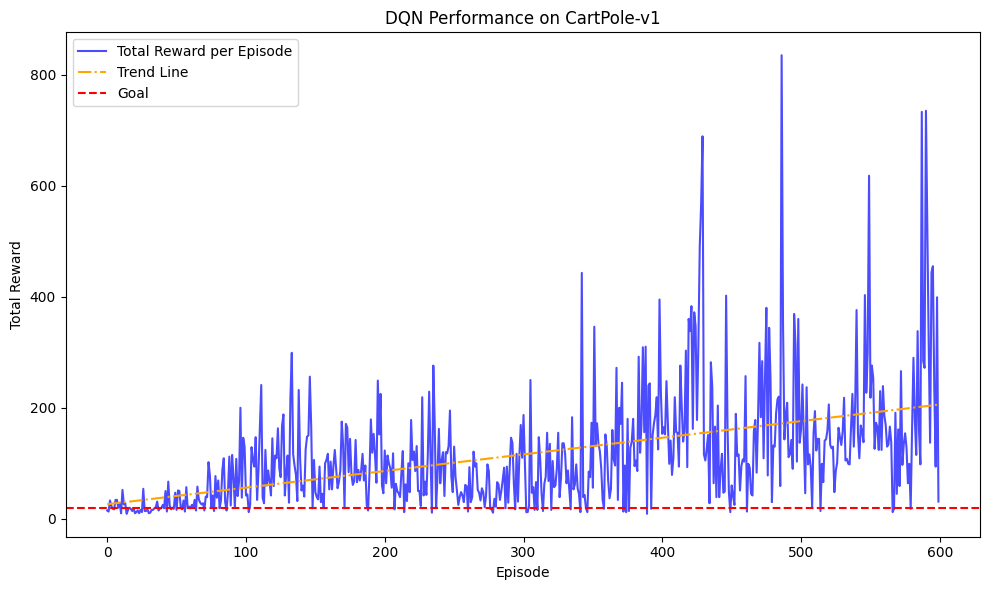

In [18]:
goal = 20

episodes = np.arange(len(rewards_per_episode))
average_reward = np.mean(rewards_per_episode)
stability = np.std(rewards_per_episode)

print(f"Overall Average Reward: {average_reward:.2f}")
print(f"Overall Stability (Standard Deviation): {stability:.2f}")
print(f"Total Reward: {np.sum(rewards_per_episode):.1f}")

z = np.polyfit(episodes, rewards_per_episode, 1)
p = np.poly1d(z)

# Plotting the reward per episode with trend line
plt.figure(figsize=(10, 6))
plt.plot(episodes, rewards_per_episode, label='Total Reward per Episode', color='blue', alpha=0.7)
plt.plot(episodes, p(episodes), color='orange', linestyle='-.', label='Trend Line')
plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Performance on CartPole-v1')

plt.legend()
plt.tight_layout()
plt.show()


# PPO Agent 

In [6]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers
import numpy as np
import tensorflow as tf
import gymnasium as gym
import scipy.signal
import matplotlib.pyplot as plt

In [7]:
def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )

def mlp(x, sizes, activation=tf.keras.activations.tanh, output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = tf.keras.layers.Dense(units=size, activation=activation)(x)
    return tf.keras.layers.Dense(units=sizes[-1], activation=output_activation)(x)

def logprobabilities(logits, a):
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = tf.nn.log_softmax(logits)
    logprobability = tf.reduce_sum(
        tf.one_hot(a, num_actions) * logprobabilities_all, axis=1
    )
    return logprobability

seed_generator = tf.random.Generator.from_seed(1337)

@tf.function
def sample_action(observation):
    logits = actor(observation)
    action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
    return logits, action


@tf.function
def train_policy(observation_buffer, action_buffer, logprobability_buffer, advantage_buffer):
    with tf.GradientTape() as tape:
        # Calculate logits from the actor
        logits = actor(observation_buffer)
        # Calculate new log probabilities
        new_logprobabilities = logprobabilities(logits, action_buffer)
        # Compute the ratio of new to old probabilities
        ratio = tf.exp(new_logprobabilities - logprobability_buffer)
        # Compute clipped objective function
        min_advantage = tf.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer
        )
        policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantage_buffer, min_advantage))
    
    # Compute gradients and update policy
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))
    
    # Compute KL divergence
    kl = tf.reduce_mean(logprobability_buffer - new_logprobabilities)
    return kl

@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:
        # Compute the value loss
        value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
    
    # Compute gradients and update value function
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))



In [8]:
steps_per_epoch = 4000
epochs = 10
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.97
target_kl = 0.01
hidden_sizes = (64, 64)

# True if you want to render the environment
render = False

In [9]:
env = gym.make("CartPole-v1")
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.n

# Initialize the buffer
buffer = Buffer(observation_dimensions, steps_per_epoch)

# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(observation_dimensions,), dtype="float32")
logits = mlp(observation_input, list(hidden_sizes) + [num_actions])
actor = keras.Model(inputs=observation_input, outputs=logits)
value = tf.squeeze(mlp(observation_input, list(hidden_sizes) + [1]), axis=1)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

# Initialize the observation, episode return and episode length
observation, _ = env.reset()
episode_return, episode_length = 0, 0

In [10]:
for epoch in range(epochs):
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0

    # Iterate over the steps of each epoch
    for t in range(steps_per_epoch):
        if render:
            env.render()

        # Get the logits, action, and take one step in the environment
        observation = observation.reshape(1, -1)
        logits, action = sample_action(observation)
        observation_new, reward, done, _, _ = env.step(action[0].numpy())
        episode_return += reward
        episode_length += 1

        # Get the value and log-probability of the action
        value_t = critic(observation)
        logprobability_t = logprobabilities(logits, action)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(observation, action, reward, value_t, logprobability_t)

        # Update the observation
        observation = observation_new

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic(observation.reshape(1, -1))
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            sum_length += episode_length
            num_episodes += 1
            observation, _ = env.reset()
            episode_return, episode_length = 0, 0

    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(
            observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * target_kl:
            # Early Stopping
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(observation_buffer, return_buffer)

    # Print mean return and length for each epoch
    print(
        f" Epoch: {epoch + 1}. Mean Return: {sum_return / num_episodes}"
    )

 Epoch: 1. Mean Return: 20.408163265306122
 Epoch: 2. Mean Return: 24.691358024691358
 Epoch: 3. Mean Return: 32.520325203252035
 Epoch: 4. Mean Return: 47.05882352941177
 Epoch: 5. Mean Return: 71.42857142857143
 Epoch: 6. Mean Return: 86.95652173913044
 Epoch: 7. Mean Return: 181.8181818181818
 Epoch: 8. Mean Return: 181.8181818181818
 Epoch: 9. Mean Return: 235.2941176470588
 Epoch: 10. Mean Return: 250.0


# Testing of PPO Agent Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def test_model(env, actor, num_episodes=10, render=False):
    all_returns = []  # Initialize all_returns list to store returns
    all_lengths = []

    for episode in range(num_episodes):
        observation = env.reset()
        if isinstance(observation, tuple):
            observation, _ = observation
        observation = observation.reshape(1, -1)  # Ensure correct shape

        done = False
        episode_return = 0
        episode_length = 0

        while not done:
            if render:
                env.render()

            # Sample action from the policy
            logits, action = sample_action(tf.convert_to_tensor(observation.reshape(1, -1), dtype=tf.float32))
            action = action[0].numpy()  # Convert to numpy array for env.step()
            observation_new, reward, done, _, _ = env.step(action)

            episode_return += reward
            episode_length += 1
            observation = observation_new.reshape(1, -1)  # Ensure correct shape

        all_returns.append(episode_return)  # Store episode return
        all_lengths.append(episode_length)  # Store episode length
        print(f"Episode {episode + 1}: Return = {episode_return}, Length = {episode_length}")

    mean_return = np.mean(all_returns)
    mean_length = np.mean(all_lengths)
    
    # Return the collected data for plotting in the next cell
    return all_returns, mean_return, mean_length

# Example usage
all_returns, mean_return, mean_length = test_model(env, actor, num_episodes=300)


Episode 1: Return = 172.0, Length = 172
Episode 2: Return = 163.0, Length = 163
Episode 3: Return = 175.0, Length = 175
Episode 4: Return = 752.0, Length = 752
Episode 5: Return = 305.0, Length = 305
Episode 6: Return = 233.0, Length = 233
Episode 7: Return = 104.0, Length = 104
Episode 8: Return = 602.0, Length = 602
Episode 9: Return = 210.0, Length = 210
Episode 10: Return = 347.0, Length = 347
Episode 11: Return = 350.0, Length = 350
Episode 12: Return = 263.0, Length = 263
Episode 13: Return = 252.0, Length = 252
Episode 14: Return = 266.0, Length = 266
Episode 15: Return = 559.0, Length = 559
Episode 16: Return = 137.0, Length = 137
Episode 17: Return = 107.0, Length = 107
Episode 18: Return = 344.0, Length = 344
Episode 19: Return = 224.0, Length = 224
Episode 20: Return = 284.0, Length = 284
Episode 21: Return = 334.0, Length = 334
Episode 22: Return = 1519.0, Length = 1519
Episode 23: Return = 138.0, Length = 138
Episode 24: Return = 90.0, Length = 90
Episode 25: Return = 161.

Graph Comparision

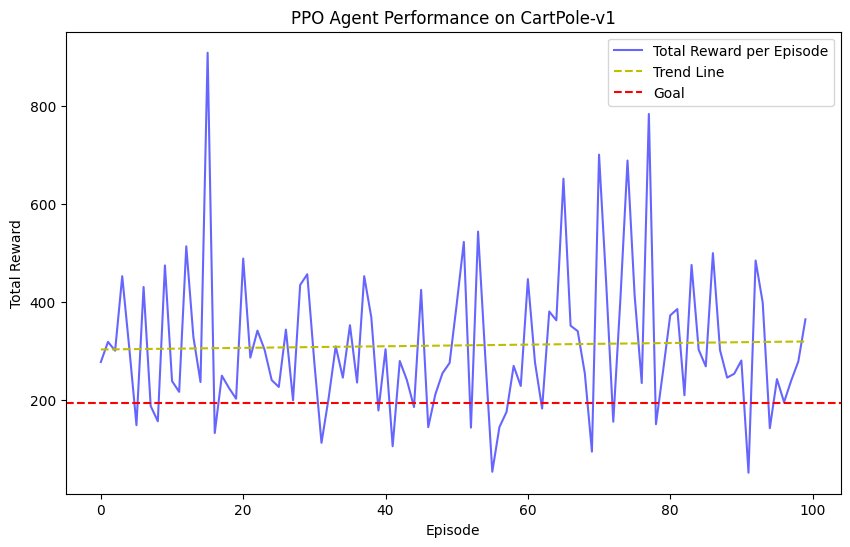

In [12]:
# Plotting the results in a separate cell
plt.figure(figsize=(10, 6))
plt.plot(all_returns, label='Total Reward per Episode', color='blue', alpha=0.6)

# Adding a trend line
z = np.polyfit(range(len(all_returns)), all_returns, 1)
p = np.poly1d(z)
plt.plot(range(len(all_returns)), p(range(len(all_returns))), "y--", label='Trend Line')

# Optionally adding a goal line
goal = 195  # Example goal value
plt.axhline(y=goal, color='r', linestyle='--', label='Goal')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Agent Performance on CartPole-v1')
plt.legend()
plt.show()
